# 2-Modelling

### Importing Libraries

In [1]:
# Basic Libraries
import pandas as pd
import numpy as np
import os

# Plotting Libraries
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm  # Progress bar
import warnings

import functions as f
import statsmodels.formula.api as smf

# Machine Learning Libraries
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix,  accuracy_score, classification_report, roc_auc_score, roc_curve
from sklearn.metrics import ConfusionMatrixDisplay, r2_score, mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV,  KFold, cross_validate, RandomizedSearchCV

# Machine Learning Models
from sklearn.linear_model import LogisticRegression, LinearRegression, Ridge, Lasso, ElasticNet
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, StackingClassifier, AdaBoostClassifier, BaggingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
import sklearn
from itertools import combinations  # For best subset selection
import math

# Optimization Libraries
import optuna 

# Deep Learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import callbacks
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras import regularizers
from tensorflow.keras import optimizers

os.chdir('/Users/aimlessfox/Desktop/Projects/intro-ds-shenanigans/trials')

np.random.seed(42)

os.chdir('..')

/Users/aimlessfox/anaconda3/envs/MSDS/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
df = pd.read_csv('data/weather_EL.csv')

In [3]:
df.dt_iso = pd.to_datetime(df.dt_iso, format= "%Y-%m-%d %H:%M:%S %z UTC")

In [4]:
df_new = df.drop(labels=["sea_level", "grnd_level", "wind_gust", "rain_1h", "rain_3h", "snow_1h", "snow_3h", 'dt', 'lat','lon','city_name', 'timezone', 'weather_icon', 'weather_main', 'weather_description'], axis = 1)

In [5]:
df_new['hour'] = df_new.dt_iso.dt.hour

In [6]:
df_new.head()

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4


In [7]:
df_new.shape

(414847, 14)

In [8]:
df_new.isna().sum()

dt_iso            0
temp              0
visibility    54063
dew_point         0
feels_like        0
temp_min          0
temp_max          0
pressure          0
humidity          0
wind_speed        0
wind_deg          0
clouds_all        0
weather_id        0
hour              0
dtype: int64

### Data Imputation

In [9]:
# imputer df = df_new ['temp', 'pressure', 'humidity', 'visibility']

imputer_df = df_new[['temp', 'pressure', 'humidity', 'visibility']]
imputer_df

,temp,pressure,humidity,visibility
0,272.63,1012,95,4000.0
1,272.63,1012,95,4000.0
2,272.14,1011,97,NaN
3,272.11,1010,95,4000.0
4,272.35,1010,95,4000.0
...,...,...,...,...
414842,280.50,1019,58,10000.0
414843,281.07,1017,57,10000.0
414844,280.75,1016,54,10000.0
414845,280.14,1017,50,10000.0


In [10]:
imputer_df1 = imputer_df.dropna(axis = 0, how = 'any')

In [11]:
imputer_df1

,temp,pressure,humidity,visibility
0,272.63,1012,95,4000.0
1,272.63,1012,95,4000.0
3,272.11,1010,95,4000.0
4,272.35,1010,95,4000.0
5,272.34,1011,92,4000.0
...,...,...,...,...
414842,280.50,1019,58,10000.0
414843,281.07,1017,57,10000.0
414844,280.75,1016,54,10000.0
414845,280.14,1017,50,10000.0


In [12]:
X, y = imputer_df1.drop('visibility', axis=1), imputer_df1['visibility']

In [13]:
from sklearn.linear_model import LinearRegression

# Create a linear regression model
imputer_model = LinearRegression()

In [14]:
imputer_model.fit(X.dropna(), y.dropna())

# Predict missing values
missing_values = imputer_df[imputer_df['visibility'].isnull()][['temp', 'pressure', 'humidity']]
predicted_values = imputer_model.predict(missing_values)

imputer_df.loc[imputer_df['visibility'].isnull(), 'visibility'] = predicted_values

In [15]:
# Save imputer_model
import pickle
# pickle.dump(imputer_model, open('models/Data Imputation/imputer_model.pkl', 'wb'))

In [16]:
predicted_values

array([6797.954145  , 7178.49731088, 7300.43610184, ..., 8245.11119808,
       7987.27481828, 7078.33639116])

In [17]:
imputer_df

,temp,pressure,humidity,visibility
0,272.63,1012,95,4000.000000
1,272.63,1012,95,4000.000000
2,272.14,1011,97,6797.954145
3,272.11,1010,95,4000.000000
4,272.35,1010,95,4000.000000
...,...,...,...,...
414842,280.50,1019,58,10000.000000
414843,281.07,1017,57,10000.000000
414844,280.75,1016,54,10000.000000
414845,280.14,1017,50,10000.000000


In [18]:
df_imputed = df_new.copy()
df_imputed.loc[df_imputed['visibility'].isnull(), 'visibility'] = predicted_values

In [19]:
df_imputed

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.000000,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.000000,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,6797.954145,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.000000,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.000000,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414842,2022-03-22 19:00:00+00:00,280.50,10000.000000,272.83,280.50,279.47,281.22,1019,58,0.89,68,90,804,19
414843,2022-03-22 20:00:00+00:00,281.07,10000.000000,273.09,280.12,279.53,281.56,1017,57,1.79,90,90,500,20
414844,2022-03-22 21:00:00+00:00,280.75,10000.000000,272.17,280.75,279.53,281.22,1016,54,0.89,90,90,500,21
414845,2022-03-22 22:00:00+00:00,280.14,10000.000000,270.75,277.67,278.79,280.45,1017,50,3.60,120,90,500,22


In [20]:
df_imputed.to_csv('data/Imputed_Weather_EL.csv', index=False)

In [21]:
df_new

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414842,2022-03-22 19:00:00+00:00,280.50,10000.0,272.83,280.50,279.47,281.22,1019,58,0.89,68,90,804,19
414843,2022-03-22 20:00:00+00:00,281.07,10000.0,273.09,280.12,279.53,281.56,1017,57,1.79,90,90,500,20
414844,2022-03-22 21:00:00+00:00,280.75,10000.0,272.17,280.75,279.53,281.22,1016,54,0.89,90,90,500,21
414845,2022-03-22 22:00:00+00:00,280.14,10000.0,270.75,277.67,278.79,280.45,1017,50,3.60,120,90,500,22


### Exploring Machine Learnable Features

In [22]:
df_new

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
414842,2022-03-22 19:00:00+00:00,280.50,10000.0,272.83,280.50,279.47,281.22,1019,58,0.89,68,90,804,19
414843,2022-03-22 20:00:00+00:00,281.07,10000.0,273.09,280.12,279.53,281.56,1017,57,1.79,90,90,500,20
414844,2022-03-22 21:00:00+00:00,280.75,10000.0,272.17,280.75,279.53,281.22,1016,54,0.89,90,90,500,21
414845,2022-03-22 22:00:00+00:00,280.14,10000.0,270.75,277.67,278.79,280.45,1017,50,3.60,120,90,500,22


In [48]:
df_new_1 = df_new.copy()
df_new_1.head()

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.0,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.0,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,NaN,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.0,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.0,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4


In [49]:
df_new_1 = df_new_1.drop(labels=['dt_iso','feels_like', 'temp_min', 'temp_max' ], axis = 1)

In [50]:
df_new_1.dropna(axis = 0, how = 'any', inplace = True)

In [51]:
df_new_1.sample(frac=1, random_state = 193).reset_index()
X, y = df_new_1.drop('weather_id', axis=1), df_new_1['weather_id']
X

,temp,visibility,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,hour
0,272.63,4000.0,272.01,1012,95,5.70,40,90,0
1,272.63,4000.0,272.01,1012,95,5.70,40,90,1
3,272.11,4000.0,271.49,1010,95,6.20,20,90,3
4,272.35,4000.0,271.73,1010,95,6.20,20,90,4
5,272.34,4000.0,271.34,1011,92,6.10,360,90,5
...,...,...,...,...,...,...,...,...,...
414842,280.50,10000.0,272.83,1019,58,0.89,68,90,19
414843,281.07,10000.0,273.09,1017,57,1.79,90,90,20
414844,280.75,10000.0,272.17,1016,54,0.89,90,90,21
414845,280.14,10000.0,270.75,1017,50,3.60,120,90,22


In [52]:
import functions as f

In [53]:
# output the process for a function in a .py file
from importlib import reload

reload(f)

<module 'functions' from '/Users/aimlessfox/Desktop/Projects/intro-ds-shenanigans/trials/functions.py'>

Best R2 with 9 Features: 0.2610: 100%|██████████| 1/1 [00:00<00:00, 18.16it/s]


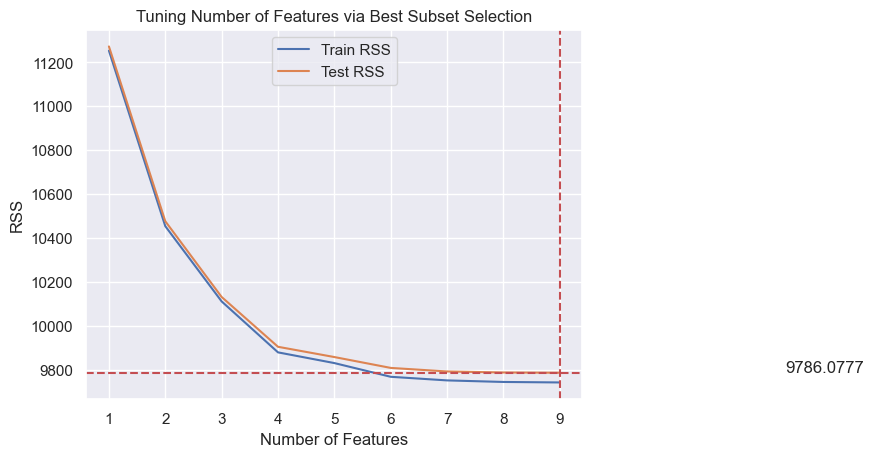

In [54]:
no_impute_models = f.best_subset(X, y)
best_subset, best_model, best_r2, best_rss = no_impute_models[0], no_impute_models[1], no_impute_models[2], no_impute_models[3]

In [55]:
# Fit model with statsmodels and view summary
best_model_no_impute = best_model
formula = "weather_id ~ " + "+".join(best_model_no_impute.feature_names_in_)
smf.ols(formula, df_new_1).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             weather_id   R-squared:                       0.261
Model:                            OLS   Adj. R-squared:                  0.261
Method:                 Least Squares   F-statistic:                 1.416e+04
Date:                Wed, 27 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:31:14   Log-Likelihood:            -2.1687e+06
No. Observations:              360784   AIC:                         4.337e+06
Df Residuals:                  360774   BIC:                         4.337e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -664.4847     27.961    -23.765      0.000    -719.287    -609.682
temp          -4.0680      0.211    -19.248      0.000      -4.482      -3.654
visibility     0.0062   7.86e-05     78.359      0.000       0.006       0.006
dew_point      3.5039      0.224     15.616      0.000       3.064       3.944
pressure       1.7226      0.025     68.237      0.000       1.673       1.772
humidity      -2.3228      0.052    -44.586      0.000      -2.425      -2.221
wind_speed    -3.7299      0.079    -47.085      0.000      -3.885      -3.575
wind_deg       0.0150      0.002      9.103      0.000       0.012       0.018
clouds_all    -0.6600      0.005   -127.756      0.000      -0.670      -0.650
hour          -0.6203      0.026    -23.936      0.000      -0.671      -0.570
==============================================================================
Omnibus:                   118389.370   Durbin-Watson:                   1.294
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           374707.893
Skew:                          -1.703   Prob(JB):                         0.00
Kurtosis:                       6.651   Cond. No.                     1.55e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.55e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [57]:
df_new_2 = df_imputed.copy()
df_new_2.head()

,dt_iso,temp,visibility,dew_point,feels_like,temp_min,temp_max,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,1979-01-01 00:00:00+00:00,272.63,4000.000000,272.01,267.19,271.97,274.06,1012,95,5.70,40,90,741,0
1,1979-01-01 01:00:00+00:00,272.63,4000.000000,272.01,267.19,272.03,274.06,1012,95,5.70,40,90,741,1
2,1979-01-01 02:00:00+00:00,272.14,6797.954145,271.77,267.71,271.72,274.06,1011,97,3.89,9,100,804,2
3,1979-01-01 03:00:00+00:00,272.11,4000.000000,271.49,266.28,271.50,274.06,1010,95,6.20,20,90,741,3
4,1979-01-01 04:00:00+00:00,272.35,4000.000000,271.73,266.58,271.81,274.06,1010,95,6.20,20,90,741,4


In [58]:
df_new_2 = df_new_2.drop(labels=['dt_iso','feels_like', 'temp_min', 'temp_max' ], axis = 1)
df_new_2.head()

,temp,visibility,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,weather_id,hour
0,272.63,4000.000000,272.01,1012,95,5.70,40,90,741,0
1,272.63,4000.000000,272.01,1012,95,5.70,40,90,741,1
2,272.14,6797.954145,271.77,1011,97,3.89,9,100,804,2
3,272.11,4000.000000,271.49,1010,95,6.20,20,90,741,3
4,272.35,4000.000000,271.73,1010,95,6.20,20,90,741,4


In [59]:
df_new_2.sample(frac=1, random_state = 193).reset_index()
X, y = df_new_2.drop('weather_id', axis=1), df_new_2['weather_id']
X

,temp,visibility,dew_point,pressure,humidity,wind_speed,wind_deg,clouds_all,hour
0,272.63,4000.000000,272.01,1012,95,5.70,40,90,0
1,272.63,4000.000000,272.01,1012,95,5.70,40,90,1
2,272.14,6797.954145,271.77,1011,97,3.89,9,100,2
3,272.11,4000.000000,271.49,1010,95,6.20,20,90,3
4,272.35,4000.000000,271.73,1010,95,6.20,20,90,4
...,...,...,...,...,...,...,...,...,...
414842,280.50,10000.000000,272.83,1019,58,0.89,68,90,19
414843,281.07,10000.000000,273.09,1017,57,1.79,90,90,20
414844,280.75,10000.000000,272.17,1016,54,0.89,90,90,21
414845,280.14,10000.000000,270.75,1017,50,3.60,120,90,22


Best R2 with 9 Features: 0.2541: 100%|██████████| 1/1 [00:00<00:00, 15.41it/s]


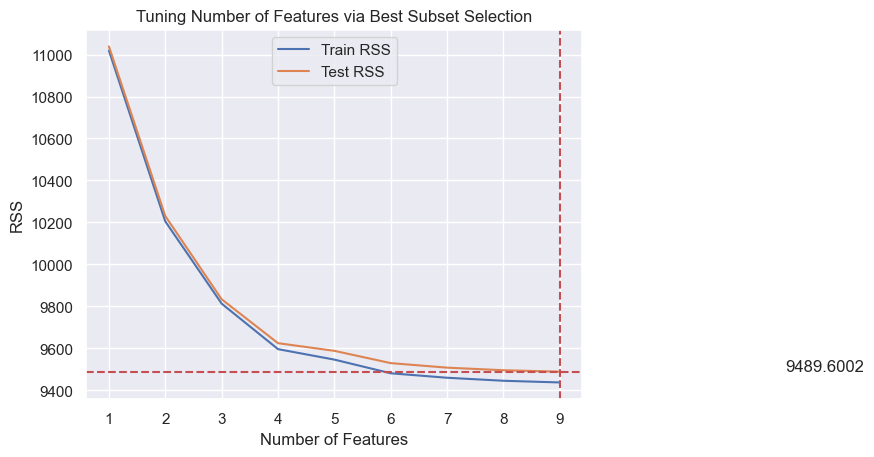

In [60]:
impute_models = f.best_subset(X, y)
best_subset, best_model, best_r2, best_rss = impute_models[0], impute_models[1], impute_models[2], impute_models[3]

In [61]:
# Fit model with statsmodels and view summary
best_model_impute = best_model
formula = "weather_id ~ " + "+".join(best_model_impute.feature_names_in_)
smf.ols(formula, df_new_2).fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:             weather_id   R-squared:                       0.254
Model:                            OLS   Adj. R-squared:                  0.254
Method:                 Least Squares   F-statistic:                 1.571e+04
Date:                Wed, 27 Dec 2023   Prob (F-statistic):               0.00
Time:                        11:48:11   Log-Likelihood:            -2.4871e+06
No. Observations:              414847   AIC:                         4.974e+06
Df Residuals:                  414837   BIC:                         4.974e+06
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   -771.9730     25.923    -29.780      0.000    -822.780    -721.166
temp          -5.4233      0.197    -27.578      0.000      -5.809      -5.038
visibility     0.0061   7.66e-05     80.233      0.000       0.006       0.006
dew_point      4.9802      0.209     23.859      0.000       4.571       5.389
pressure       1.8263      0.023     78.233      0.000       1.781       1.872
humidity      -2.6545      0.048    -54.844      0.000      -2.749      -2.560
wind_speed    -4.2914      0.075    -57.319      0.000      -4.438      -4.145
wind_deg       0.0284      0.002     18.746      0.000       0.025       0.031
clouds_all    -0.5818      0.005   -126.045      0.000      -0.591      -0.573
hour          -0.7002      0.024    -29.541      0.000      -0.747      -0.654
==============================================================================
Omnibus:                   139192.978   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.000   Jarque-Bera (JB):           453967.355
Skew:                          -1.730   Prob(JB):                         0.00
Kurtosis:                       6.780   Cond. No.                     1.56e+06
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.56e+06. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

When comparing the 2 outputs, with or without imputation, we see the imputed data has a lower RSS score and all the p-values are near 0. 

We also notice that both of the 

### Regression Models